# Определение выгодного тарифа для телеком компании
## Содержание <a id='content'></a>
1. [Изучение общей информации](#viewing)
2. [Подготовка данных](#processing)
3. [Анализ данных](#analysis)
4. [Проверка гипотез](#hypotheses)
5. [Общий вывод](#conclusion)

## 1. Изучение общей информации <a id='viewing'></a>

In [1]:
# импортируем необходимые нам бибиотеки
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
# выводим информацию по каждой таблице
users = pd.read_csv('/datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [8]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


При первом просмотре данных в них не обнаружились пропущенные значения, которые требуют заполнения.  
Во всех таблицах колонки с датой имеют строковый тип, необходим их перевод в формат `datetime`.  
По условиям компании значения минут и мегабайтов всегда округляются вверх, после окргуления в этих столбцах также следует заменить тип данных на целочисленный.

## 2. Подготовка данных <a id='processing'></a>
[Назад к оглавлению](#content)

Так как в каждой таблице необходимо привести столбцы с датой к формату `datetime`, автоматизируем этот процесс при помощи функции. Она будет принимать таблицу в качестве параметра, искать слово date в названии каждого столбца и при обнаружении приводить этот столбец к интересующему нас типу.

In [12]:
def to_datetime(data):
    columns = data.columns # создаем список с названиями столбцов
    for column in columns:
        column.split('_') # раздеяем название, индикатором разделения служит указаный символ
        if 'date' in column:
            data[column] = pd.to_datetime(data[column]) # переводим в правильный формат

Применим эту функцию в цикле для каждой таблицы:

In [13]:
data_list = [users, calls, messages, internet, tariffs] # создаем список с нашими таблицами
for data in data_list:
    to_datetime(data)

In [54]:
# проверяем
for data in data_list:
    data.info()
    print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non

Ранее мы определили, что по условиям компании все звонки и мегабайты округляются вверх.  
Применим это округления для таблиц `calls` и `internet` при помощи метода *ceil* библиотеки *math*. Данный метод автоматически переведёт соответствующие столбцы в целочисленный тип.

In [15]:
calls['duration'] = calls['duration'].agg(mt.ceil)

In [16]:
internet['mb_used'] = internet['mb_used'].agg(mt.ceil)

In [17]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


Cледует обратить внимание, что длительность некоторых звонков равна 0 минут. Скорее всего они обозначают пропущенные звонки и обрабатывать их не нужно, поскольку это повлияет на количество сделанных пользователем звонков и исказит данные.

In [18]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113,2018-11-25,1000
1,1,1000_1,1053,2018-09-07,1000
2,2,1000_2,1198,2018-06-25,1000
3,3,1000_3,551,2018-08-22,1000
4,4,1000_4,303,2018-09-24,1000


В этой таблице также можем удалить неинформативный столбец `Unnamed: 0`

In [19]:
internet.drop('Unnamed: 0', axis=1, inplace=True)

Далее нам необходимо посчитать для каждого пользователя:  
- количество сделанных звонков и израсходованных минут разговора по месяцам;  
- количество отправленных сообщений по месяцам;  
- объем израсходованного интернет-трафика по месяцам;  
- помесячную выручку с каждого пользователя.

Добавим в каждую из трех таблиц (звонки, смс, интернет) столбец с номером месяца `month`, в котором происходила активность:

In [20]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

Создаем сводную таблицу по звонкам путём группировки таблицы `calls` по id пользователей и месяцам. В ней подсчитаем количество строк с длительностью звонков и их сумму.

In [56]:
calls_duration = (calls
                  .groupby(by=['user_id', 'month'])['duration']
                  .agg(['count', 'sum'])
                  .reset_index()
                 )
calls_duration.head()

,user_id,month,count,sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


Аналогично для таблицы `messages` вычислим количество отправленных смс:

In [55]:
messages_sent = (messages
                 .groupby(by=['user_id', 'month'])['id']
                 .count()
                 .reset_index()
                )
messages_sent.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


И сумму мегабайт для `internet`:

In [57]:
internet_used = (internet
                 .groupby(by=['user_id', 'month'])['mb_used']
                 .sum()
                 .reset_index()
                )
internet_used.head()

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


При помощи метода `merge` объединим полученные таблицы в одну общую. Склейку будем производить сразу по двум столбцам - `user_id` и `month`. В качестве параметра типа объединения укажем внешний, чтобы данные не были потеряны в случаях, когда какой-то вид связи за месяц ни разу не был применён. Итоговую таблицу поместим в новую переменную `users_data`.

In [58]:
users_data = (pd
              .merge(left=calls_duration, right=messages_sent, on=['user_id', 'month'], how='outer') # объединяем звонки и смс
              .merge(right=internet_used, on=['user_id', 'month'], how='outer') # добавляем интернет
              .merge(right=users[['user_id', 'city', 'tariff']], on='user_id', how='inner') # добавляем нужные нам столбцы из users
              .sort_values(['user_id', 'month']) # сортируем по пользователяем и месяцам
              .reset_index(drop=True)
             )
users_data.head()

,user_id,month,count,sum,id,mb_used,city,tariff
0,1000,5,22.0,159.0,22.0,2256.0,Краснодар,ultra
1,1000,6,43.0,172.0,60.0,23257.0,Краснодар,ultra
2,1000,7,47.0,340.0,75.0,14016.0,Краснодар,ultra
3,1000,8,52.0,408.0,81.0,14070.0,Краснодар,ultra
4,1000,9,58.0,466.0,57.0,14581.0,Краснодар,ultra


Для убодства переименуем названия столбцов:

In [26]:
users_data.columns = ['user_id', 'month', 'calls_total', 'minutes_sum', 'messages', 'mb', 'city', 'tariff']
users_data.head()

,user_id,month,calls_total,minutes_sum,messages,mb,city,tariff
0,1000,5,22.0,159.0,22.0,2256.0,Краснодар,ultra
1,1000,6,43.0,172.0,60.0,23257.0,Краснодар,ultra
2,1000,7,47.0,340.0,75.0,14016.0,Краснодар,ultra
3,1000,8,52.0,408.0,81.0,14070.0,Краснодар,ultra
4,1000,9,58.0,466.0,57.0,14581.0,Краснодар,ultra


In [27]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id        3214 non-null int64
month          3214 non-null int64
calls_total    3174 non-null float64
minutes_sum    3174 non-null float64
messages       2717 non-null float64
mb             3203 non-null float64
city           3214 non-null object
tariff         3214 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 201.0+ KB


После объединения таблицы столбцы `calls_total`, `minutes_sum`, `messages` и `mb` преобразовались в тип float64 из-за появившихся в них пропущенных значений, которые возникли после склейки по внейшнему типу. Заполним пропуски нулями и вернем столбцы к целочисленному типу:

In [28]:
users_data.fillna(0, inplace=True)

In [29]:
users_data[['calls_total', 'minutes_sum', 'messages', 'mb']] = users_data[['calls_total', 'minutes_sum', 'messages', 'mb']].astype(int)

Также объединим текущий датафрейм с таблицей `tariffs`, чтобы отобразилась информация о принадлежности каждого абонента к одному из двух тарифов и об условиях их использования:

In [30]:
users_data = users_data.merge(right=tariffs, how='left', left_on='tariff', right_on='tariff_name')
users_data.head()

,user_id,month,calls_total,minutes_sum,messages,mb,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,22,159,22,2256,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,43,172,60,23257,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,47,340,75,14016,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,52,408,81,14070,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,58,466,57,14581,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra


In [31]:
users_data.drop('tariff_name', axis=1, inplace=True) # удаляем последний столбцец, дублирующий tariff
users_data.head()

,user_id,month,calls_total,minutes_sum,messages,mb,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22,159,22,2256,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43,172,60,23257,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47,340,75,14016,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52,408,81,14070,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58,466,57,14581,Краснодар,ultra,1000,30720,3000,1950,150,1,1


Теперь необходимо посчитать помесячную выручку с каждого пользователя. Для этого добавим 3 столбца с выручкой по звонкам, сообщениям и интернету:

In [32]:
users_data['minutes_over'] = (users_data['minutes_sum'] - users_data['minutes_included'])
users_data['messages_over'] = (users_data['messages'] - users_data['messages_included']) 
users_data['internet_over'] = (users_data['mb'] - users_data['mb_per_month_included']) 

Те строки, где получились отрицательные значения, заменим на 0. Это означает, что у абонента не было никаких дополнительных списаний поверх тарифного плана:

In [33]:
users_data.loc[users_data['minutes_over'] < 0, 'minutes_over'] = 0
users_data.loc[users_data['messages_over'] < 0, 'messages_over'] = 0
users_data.loc[users_data['internet_over'] < 0, 'internet_over'] = 0

Общая выручка с каждого пользователя будет складываться из перерасхода минут, сообщений и мегабайт, умноженных на их стоимость вне пакета, а также абонентской платы тарифа.  
Так как стоимость для интернета указана за 1 гигабайт, а столбец `internet_over` показывает значение в мегабайтах, необходимо это значение разделить на 1024 и округлить до целого числа в большую сторону методом *ceil*.

In [34]:
users_data['total_income'] = (users_data['minutes_over'] * users_data['rub_per_minute'] # прибыль со звонков
                              + users_data['messages_over'] * users_data['rub_per_message'] # прибыль с сообщений
                              + (users_data['internet_over'] / 1024).agg(mt.ceil) * users_data['rub_per_gb'] # прибыль с интернета
                              + users_data['rub_monthly_fee']) # абонентская плата   

In [35]:
users_data.head()

,user_id,month,calls_total,minutes_sum,messages,mb,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over,messages_over,internet_over,total_income
0,1000,5,22,159,22,2256,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
1,1000,6,43,172,60,23257,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
2,1000,7,47,340,75,14016,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
3,1000,8,52,408,81,14070,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
4,1000,9,58,466,57,14581,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950


Таким образом мы подготовили исходные данные для дальнейших исследований: привели данные к нужным типам, нашли и исправили ошибки и собрали общую таблицу, по которой можно изучить поведение клиентов выборки. Теперь мы знаем помесячную выручку по каждому абоненту, а также перерасход минут, сообщений и мегабайт.

## 3. Анализ данных <a id='analysis'></a>
[Назад к оглавлению](#content)

На данном этапе мы опишем **поведение клиентов** оператора, исходя из выборки.  
Нужно вычислить, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Для каждого параметра посчитаем среднее количество, дисперсию и стандартное отклонение и построим по ним гистограммы.

Разделим абонентов на 2 группы в зависимости от используемого ими тарифа. Они будут храниться в двух новых таблицах - `smart_users` и `ultra_users`.

In [36]:
smart_users = users_data.query('tariff == "smart"')
ultra_users = users_data.query('tariff =="ultra"')

Для тарифа **Smart** создадим 3 сводные таблицы, сгруппированные по пользователю и месяцу и подсчитаем среднее количество звонков, смс и использованных мегабайт:

In [37]:
smart_calls = smart_users.pivot_table(index=['user_id', 'month'], values='minutes_sum').reset_index()
smart_messages = smart_users.pivot_table(index=['user_id', 'month'], values='messages').reset_index()
smart_internet = smart_users.pivot_table(index=['user_id', 'month'], values='mb').reset_index()

То же самое для тарифа **Ultra**:

In [38]:
ultra_calls = ultra_users.pivot_table(index=['user_id', 'month'], values='minutes_sum').reset_index()
ultra_messages = ultra_users.pivot_table(index=['user_id', 'month'], values='messages').reset_index()
ultra_internet = ultra_users.pivot_table(index=['user_id', 'month'], values='mb').reset_index()

Для построения распределений по этим таблицам напишем функцию, которая на вход будет принимать группу сводных таблиц для каждого тарифа, а также кодировку цвета, чтобы наши тарифы было проще различать. Функция будет строить **гистограммы значений** по каждому месяцу для трёх исследуемых параметров и автоматически вычислять для них **среднее значение, дисперсию и стандартное отклонение**.

In [39]:
smart_data_list = [smart_calls, smart_messages, smart_internet]
ultra_data_list = [ultra_calls, ultra_messages, ultra_internet]

In [61]:
def distr(data_list, color):
    for data in data_list:
        data.columns = ['user_id', 'month', 'total']
        plot = sns.catplot(x='month', y='total', kind='bar', palette=color,  data=data, ci=None)
        plot.set_axis_labels('Месяц', 'Среднее количество')
        plt.show()
        desc = data['total'].describe()
        print('Среднее количество: {:.1f}'.format(data['total'].mean()))
        print('Дисперсия: {:.1f}'.format(np.var(data['total'], ddof=1)))
        print('Стандартное отклонение: {:.1f}'.format(np.std(data['total'], ddof=1)))

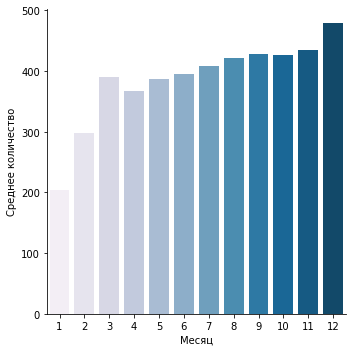

Среднее количество: 417.9
Дисперсия: 36219.3
Стандартное отклонение: 190.3


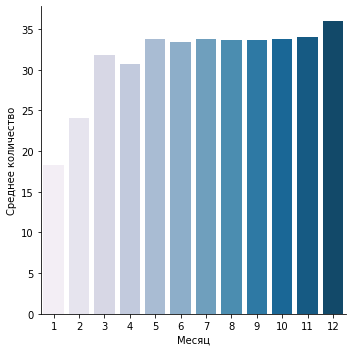

Среднее количество: 33.4
Дисперсия: 796.8
Стандартное отклонение: 28.2


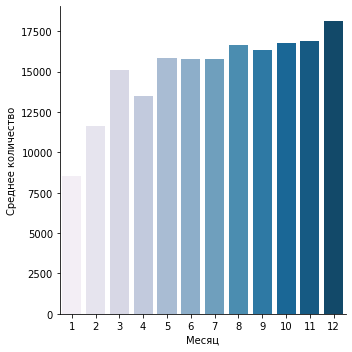

Среднее количество: 16229.2
Дисперсия: 34545911.1
Стандартное отклонение: 5877.6


In [62]:
distr(smart_data_list, 'PuBu')

Для тарифа **Smart** распределения по трем параметрам напоминает экспоненциальное, в начале года среднее число по всем параметрам заметно ниже, чем в конце. Однако, в середине значения примерно одинаковые, особенно отчетливо это наблюдается на диаграмме сообщений (2).  
Для **звонков** среднее количество составляет 418 минут, это означает, что в среднем абоненты данного тарифа укладываются в предоставляемый бесплатный лимит. Стандартное отклонение равняется 190 минут, что означает достаточно большой разброс данных среди пользователей, многие из них сильно отклоняются от показателя среднего значения.  
**Сообщений** в среднем отправляется чуть больше 30, здесь клиенты тоже укладываются в предоставленные пакетом 50 смс.  Тем не менее, стандартное отклонение здесь тоже довольно большое - 28.  
**Интернетом** абоненты пользуются особенно активно - в среднем количество использованных гигабайт превышает включенные 15. Отсюда можем сделать вывод, что по этому параметру происходит больше всего доплат помимо месячной абонентской платы .

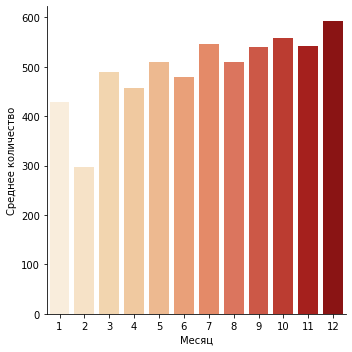

Среднее количество: 526.6
Дисперсия: 100873.6
Стандартное отклонение: 317.6


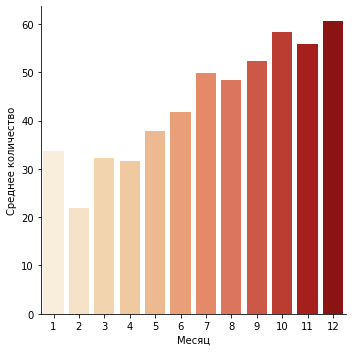

Среднее количество: 49.4
Дисперсия: 2285.3
Стандартное отклонение: 47.8


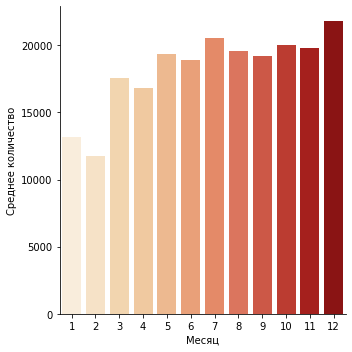

Среднее количество: 19486.9
Дисперсия: 101935621.0
Стандартное отклонение: 10096.3


In [42]:
distr(ultra_data_list, 'OrRd')

Похожее распределение наблюдается и для тарифа **Ultra**, однако здесь оно не такое линейное.  
Среднее количество **звонков** составляет 526, что ожидаемо выше, чем в первом тарифе. Стандартное отклонение здесь также больше. Возможно, причина в том, что некоторые клиенты используют больший предоставляемый объем для других целей, например интернета.  
Стандартное отклонение для **сообщений** еще больше относительно среднего количества - эти значения практически равны.  
**Интернет** также используется достаточно активно, при этом в среднем пользователям хватает 30 гигабайт, входящих в пакет. С другой стороны, доплаты сверх тарифа чаще всего происходят именно по этому показателю.

Подсчитаем долю абонентов, которые в месяц тратят **больше стоимости абонентской платы**  
Для тарифа Smart:

In [43]:
len(smart_users.query('total_income > 550')) / len(smart_users)

0.746971736204576

И для Ultra:

In [44]:
len(ultra_users.query('total_income > 1950')) / len(ultra_users)

0.13604060913705585

Среди обладателей тарифа **Smart** целых 75% не вписываются в месячный лимит по видам связи и доплачивают сверх абонентской платы, тогда как доля таких абонентов в тарифе **Ultra** составляет всего 13%.

Произведем подсчет общей выручки с каждого тарифа:

In [45]:
smart_users['total_income'].sum()

2885751

In [46]:
ultra_users['total_income'].sum()

2040000

Теперь вычислим какая выручка приходится на каждого пользователя исследуемых тарифов. Для этого разделдим совокупный доход на количество абонентов:

In [47]:
smart_per_user = smart_users['total_income'].sum() / len(smart_users)
smart_per_user

1294.6393001345896

In [48]:
ultra_per_user = ultra_users['total_income'].sum() / len(ultra_users)
ultra_per_user

2071.0659898477156

Несмотря на то, что пользователи тарифа Ultra меньше вносят дополнительных трат, за счет достаточно высокой стоимости тарифа он приносит более высокую выручку с каждого абонента - в среднем на 800 руб.  
Узнаем на сколько это больше в процентном соотношении:

In [49]:
((ultra_per_user - smart_per_user) / smart_per_user)

0.5997243322000262

Также определим соотношение количества пользователей двух тарифов:

In [50]:
len(ultra_users) / len(smart_users)

0.44190219829519967

Таким образом тариф **Ultra** приносит для компании большую выручку с одного абонента - она на 60% выше, чем выручка с тарифа **Smart**. При этом количество абонентов первого меньше на 44% и общая выручка с него за год оказалась на 30% меньше тарифа Smart.  
Компании следует привлекать больше пользователей тарифа **Ultra** для более эффективного увеличения объема прибыли.

## 4. Проверка гипотез <a id='hypotheses'></a>
[Назад к оглавлению](#content)

На этом этапе мы проверим могут ли различия двух исследуемых тарифов оказаться случайными, для чего применим **статистическую проверку гипотез**.  
Сформилируем гипотезы, которые будут проверять различаются ли между собой два исследуемых тарифа по получаемому доходу и различны ли доходы от абонентов из Москвы и регионов.

Чтобы сравнить эти две выборки, нам нужно проверить гипотезу о **равенстве среднего двух генеральных совокупностей** по взятым из них выборкам.  
В первом тесте нулевая гипотеза будет звучать следующим образом: **"среднее рассматриваемой генеральной совокупности абонентов с тарифом Smart равно среднему генеральной совокупности абонентов с тарифом Ultra"**. Следовательно, альтернативная гипотеза будет утверждать, что эти две генеральные совокупности между собой не равны.  
Для проверки нулевой гипотезы проведем **t-test**. Уровень значимости обозначим 5%. Если полученное значение p-value окажется меньше, чем alpha - мы отвергаем нулевую гипотезу. Если больше - отвергнуть мы ее не можем.

In [51]:
alpha = 0.05
results = st.ttest_ind(smart_users['total_income'], ultra_users['total_income'])
print('p-значение:', results.pvalue)
results.pvalue
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


Мы получили значение p-value значительно меньше указанного нами уровня статистической значимости, а значит мы **не можем принять нулевую гипотезу о равенстве двух генеральных совокупностей**.

Второй тест будет проводиться по тому же принципу. Нулевая гипотеза здесь: **"среднее рассматриваемой генеральной совокупности абонентов из Москвы равно среднему генеральной совокупности абонентов из регионов"**. Альтернаятивная гипотеза - эти генеральные совокупности не равны. Тип теста и уровень значимости будет аналогичен предыдущему.

Из общей таблицы `users_data` выделим в отдельные датафреймы срез абонентов из Москвы и остальных регионов:

In [52]:
moscow_users = users_data.query('city == "Москва"')
region_users = users_data.query('city != "Москва"')

In [53]:
alpha = 0.05
results = st.ttest_ind(moscow_users['total_income'], region_users['total_income'])
print('p-значение:', results.pvalue)
results.pvalue
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


По результатам проверки нулевой гипотезы p-значение превысило заданный нами 5%-ный порог, а значит у нас **недостаточно оснований для опровержения гипотезы о равенстве двух генеральных совокупностей**.

## 5. Вывод  <a id='conclusion'></a>
[Назад к оглавлению](#content)

Таким образом мы провели предварительный анализ тарифов на выборке клиентов, по результатам которой мы можем сделать выводы о поведении абонентов всей генеральной  совокупности. Для проведения такого анализа в нашем распорядении была выборка из 500 человека, среди которых пользователи двух тарифов компании - Smart и Ultra. По каждому клиенту была информация о совершенных им звонках, отправленных смс-сообщений и использованных мегабайт, а также к какому региону относился абонент и каким тарифом пользовался.  
При изучении предоставленных исходных таблиц нами были обнаружены ряд ошибок, которые затрудняли дальнейшее исследование:
- неверный тип даных в столбце с датой для каждой таблицы. Проблема была исправлена применением метода to_datetime;
- вывод точной информации об использованных минутах и мегабайтах, в то время как по условиям компании эти значения округляются вверх для целого числа. Здесь для корректировки приняли метод ceil из библиотеки math, при этом данные автоматически перевелись в целочисленный тип.  

При первичном анализе таблиц было обнаружен, что длительность многих звонков равна 0,0 минут. Вероятнее всего, это значение отображает пропущенные звонки и избавление от них повлекло бы за собой искажение данных а последующий анализ имел бы куда более низкую точность, поэтому все нулевые значения мы оставили без изменений.  
Далее для каждого пользователя мы подсчитали дополнительные параметры:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.  

Для этого в каждую таблицу был добавлен столбец месяца, в котором производилась активность и данные были сгруппированы по id пользователя и полученному месяцу. После этого исходные таблицы мы объединили в одну общую, по которой был виден расход для каждого клиента по месяцам (минуты, сообщения и мегабайты). Подсчет помесячной выручки для каждого пользователя производился путём вычета бесплатного лимита из суммарного количества звонков, сообщений и интернет-трафика и умножением остатка на значение из тарифного плана плюс абонентская плата, соответствующая ему.  
На следующем этапе мы производили анализ выборки по двум тарифам. Было подготовленно шесть сводных таблиц: звонки, сообщения и интернет-трафик для каждого тарифа. В них было подсчитано сколько каждый пользователь расходует тот или иной показатель каждый месяц. По построенным диаграммам средних значений мы увидели распределения, напоминающие экспоненциальные, по каждому из исследуемых параметров. Для них была характерна общая особенность - среднее количество в начале года было меньше, чем в конце.  
Для тарифа **Smart** среднее количество звонков составило 418 минут, по этим данным можем сказат, что в среднем абоненты данного тарифа укладываются в предоставляемый бесплатный лимит. Стандартное отклонение было достаточно большим - 190. Среднее количество отправленных сообщений составляло чуть больше 30, здесь клиенты тоже укладывались в предоставленные пакетом 50 смс. Стандартное отклонение практически равнялось среднему значению - 28, что показывает очень большой разброс данных. Интернетом абоненты данного тарифа пользуются особенно активно - в среднем количество использованных гигабайт превышает включенные 15. Отсюда можем сделать вывод, что по этому параметру происходит больше всего доплат помимо месячной абонентской платы.  
Для тарифа **Ultra** распределение было не таким линейным. Среднее количество звонков - 526, это ожидаемо выше, чем в первом тарифе. Разброс значений здесь также больше - стандартное отклонение больше 300 минут. Возможно, причина в том, что некоторые клиенты используют больший предоставляемый объем для других целей, например интернета. Разброс значений для отправленных сообщений оказался еще больше ближе к среднему значению 47.8 и 49.4 соответственно. Интернет также используется достаточно активно, при этом в среднем пользователям хватает 30 гигабайт, входящих в пакет. При стандартном отклонении больше 10000 мегабайт доплаты сверх тарифа чаще всего происходят именно по этому показателю.
В среднем выручка с каждого абонента тарифа **Ultra** оказалась на 60% выше - 2071 против 1294, при этом количество пользователей данного тарифа более чем в 2 раза преуменьшает этот показатель тарифа **Smart**, что обусловлено его большей ценовой доступностью. Общая выручка по двум тарифам составила 2885751 и 2040000 в пользу тарифа **Smart** - по данному показателю и с учетом большего количества пользователей он является наиболее выгодным.  
На заключительном этапе мы проверили могли ли сделанные выводы о выгоде тарифа **Ultra** оказаться случайными. Для этого использовали статистическую проверку гипотез.
Проверялись две гипотезы, сформулированные следующим образом:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.  

Для проверки этих гипотез мы применяли t-критерий Стьюдента. Пороговым уровнем значимости указали 0.05. В первом случае нулевая гипотеза о равенстве средних двух генеральных совокупностей нами была отвергнута, так как p-значение оказалось значительно ниже заданного порогового. Таким образом вывод о том, что тариф **Smart** более выгодный для компании является не случайным.  
При втором тесте p-уровень значимости оказался немногим больше альфы, поэтому здесь у нас оказалось недостаточно оснований отклонить нулевую гипотезу о равенстве выручки Москвыи регионов.